# Model Training

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    TrainerCallback
)
import evaluate
import torch
from torch.nn import BCEWithLogitsLoss
from typing import Optional, Dict
from torch import FloatTensor, tensor
import logging
from sklearn.metrics import classification_report, hamming_loss
from transformers import EvalPrediction

In [2]:
# for uploading model to hub
from huggingface_hub import notebook_login

notebook_login()

## Dataset Preparation

Will be training 3 datasets and comparing performances:
1. original goEmotions dataset
2. goEmotions + other datasets
3. goEmotions + other datasets + textattack data augmentation

In [3]:
random_seed = 1234

In [4]:
labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

label2id = {label:idx for idx, label in enumerate(labels)}
id2label = {idx:label for idx, label in enumerate(labels)}

### Load base model and tokenizer

In [5]:
model_name = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),     
    problem_type="multi_label_classification", # uses BCEWithLogitsLoss by default)
    id2label=id2label,
    label2id=label2id
) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# padding will be dynamically done in batching with DataCollatorWithPadding
def tokenize_func(examples):
    return tokenizer(examples['text'], truncation=True)

### Load datasets
Will be training 3 different datasets
- goEmotions (go)
- goEmotions + other datasets (merged)
- goEmotions + other datasets + textattack data augmentation (augmented)

In [7]:
# go
# dataset = load_from_disk('./datasets/cleaned_hf/goEmotions_cleaned')
# # merged
# dataset = load_from_disk('./datasets/cleaned_hf/merged_hf')
# augmented
dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf')

In [8]:
type(dataset['train']['labels'][1][0])

int

In [9]:
# In order to use BCEWithLogitsLoss, we need to convert labels to float or it'll give errors
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
# https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3
dataset = dataset.cast_column('labels', Sequence(feature=Value(dtype='float32')))

In [10]:
type(dataset['train']['labels'][1][6])

float

In [11]:
# before shuffle
dataset['train']['text'][:5]

["I'm sorry to hear, come see me when you die.",
 'i feel terrified because even if i have the time to write out how i feel about mr',
 'I asked at the Bodies Reveled show if they used prisoner bodies.. I got an awkward no.',
 'i feel awful for making this all about me and my flawed academia instilled value system but my brain won t shut up about it',
 'i feel so repressed when compared to dear a href http eurodancemix']

In [12]:
# shuffle training set
dataset['train'] = dataset['train'].shuffle(seed=random_seed)

In [13]:
# after shuffle
dataset['train']['text'][:5]

["I gave up trying to be 'normal' years ago. But I get your point though.",
 '@blue_north27 http://twitpic.com/4jcjr - Mmm yummy... looks like an invitation to me',
 'I feel a connection to this woman',
 'My friends are awesome! @JNBlack @koreantomcruise -- and the non Twitter ones here right now too!!',
 'People like you is also why no players want to play and stay in Orlando']

#### Calculate Class Weights

In [14]:
from generate_class_weights import generate_class_weights 

In [15]:
class_weights = generate_class_weights(dataset['train']['labels'], multi_class=False, one_hot_encoded=True)
class_weights

{0: 0.7691456243514355,
 1: 1.3645066273932254,
 2: 0.49946091644204854,
 3: 1.2860613071139386,
 4: 1.0808341029504691,
 5: 1.779591836734694,
 6: 1.401840877569033,
 7: 1.4498272152311404,
 8: 2.988308023115173,
 9: 1.549547038327526,
 10: 1.5710046629927936,
 11: 0.9356616873553545,
 12: 6.0391091797935905,
 13: 2.286948472693613,
 14: 0.8414758751182593,
 15: 1.1933025652033917,
 16: 25.210884353741495,
 17: 0.3419344917730278,
 18: 0.4463357353620105,
 19: 12.078218359587181,
 20: 0.8910438789821679,
 21: 19.488168273444348,
 22: 1.7916364515349288,
 23: 1.1817602040816326,
 24: 3.397402597402597,
 25: 0.26198527245949926,
 26: 0.8437108708025043,
 27: 0.15054127427948574}

#### Tokenization

In [16]:
# tokenize in batch
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 88944
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12721
    })
})

#### Batching and Dynamic padding

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Training
- Will be using `Trainer` instead of `SFTTrainer` because `SFTTrainer` is often for llms.

In [18]:
training_args = TrainingArguments(
    './models/augmented',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="no",
    push_to_hub=True,
    hub_private_repo=True,
    hub_model_id="augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta"
    )

#### Compute metrics function

In [19]:
# sources: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    
    # Generate classification report
    report = classification_report(
        y_true=labels,
        y_pred=y_pred,
        output_dict=True,  # Convert report to a dictionary
        zero_division=0  # Avoid division errors for missing labels
    )

    # Extract key metrics
    micro_precision = report["micro avg"]["precision"]
    micro_recall = report["micro avg"]["recall"]
    micro_f1 = report["micro avg"]["f1-score"]

    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    hamming = hamming_loss(y_true, y_pred)

    # Combine all metrics into a dictionary
    metrics = {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "weighted_f1": weighted_f1,
        "hamming_loss": hamming
    }

    return metrics



def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result
    

#### Custom Class Weighting Trainer Class

In [20]:
# Reference: https://discuss.huggingface.co/t/mullti-label-text-classification/44233/3
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: Optional[Dict[int, float]] = None, processing_class: Optional[AutoTokenizer] = None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            # dict --> FloatTensor
            if isinstance(class_weights, dict):
                # Convert to list of values and then to FloatTensor
                class_weights = tensor(list(class_weights.values()), dtype=torch.float)
                logging.info(f"Converted class_weights to FloatTensor: {class_weights}")
            elif not isinstance(class_weights, FloatTensor):
                raise ValueError("class_weights must be a dict or a FloatTensor")
            class_weights = class_weights.to(self.args.device)

        self.loss_fct = BCEWithLogitsLoss(pos_weight=class_weights)

        # If processing_class is passed, use it
        if processing_class is not None:
            self.processing_class = processing_class  # Handling tokenizer using processing_class argument
        else:
            self.processing_class = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        try:
            loss = self.loss_fct(outputs.logits.view(-1, model.num_labels), labels.view(-1, model.num_labels))
        except AttributeError:  # DataParallel
            loss = self.loss_fct(outputs.logits.view(-1, model.module.num_labels), labels.view(-1, model.num_labels))

        return (loss, outputs) if return_outputs else loss

### Train and Validation

In [21]:
# train_subset = tokenized_dataset["train"].select(range(100))
# eval_subset = tokenized_dataset["validation"].select(range(100))

In [22]:
trainer = WeightedTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

  0%|          | 0/33354 [00:00<?, ?it/s]

c:\Users\skpar\Desktop\Learning\ml\.env\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.07652531564235687, 'eval_micro_precision': 0.7647130647130647, 'eval_micro_recall': 0.5045516796906468, 'eval_micro_f1': 0.6079697131485706, 'eval_macro_precision': 0.6046804079144177, 'eval_macro_recall': 0.35797745037772055, 'eval_macro_f1': 0.41267733274464213, 'eval_weighted_precision': 0.732126731698383, 'eval_weighted_recall': 0.5045516796906468, 'eval_weighted_f1': 0.5763935398478438, 'eval_hamming_loss': 0.02766778109670878, 'eval_runtime': 26.9131, 'eval_samples_per_second': 387.396, 'eval_steps_per_second': 48.452, 'epoch': 1.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.0733375996351242, 'eval_micro_precision': 0.730858213065991, 'eval_micro_recall': 0.5344397003141867, 'eval_micro_f1': 0.6174034434620754, 'eval_macro_precision': 0.5790822553979859, 'eval_macro_recall': 0.4161854226705778, 'eval_macro_f1': 0.46111246878136225, 'eval_weighted_precision': 0.7104610433140707, 'eval_weighted_recall': 0.5344397003141867, 'eval_weighted_f1': 0.5922817143032091, 'eval_hamming_loss': 0.02816447891260859, 'eval_runtime': 26.444, 'eval_samples_per_second': 394.267, 'eval_steps_per_second': 49.312, 'epoch': 2.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.0730571523308754, 'eval_micro_precision': 0.7188565697091274, 'eval_micro_recall': 0.5773785547409973, 'eval_micro_f1': 0.6403967296609033, 'eval_macro_precision': 0.6048890549415057, 'eval_macro_recall': 0.4432798381596409, 'eval_macro_f1': 0.48980860811803045, 'eval_weighted_precision': 0.7004350284991268, 'eval_weighted_recall': 0.5773785547409973, 'eval_weighted_f1': 0.6243297739868517, 'eval_hamming_loss': 0.027571867035707433, 'eval_runtime': 28.0031, 'eval_samples_per_second': 372.315, 'eval_steps_per_second': 46.566, 'epoch': 3.0}
{'train_runtime': 2849.4971, 'train_samples_per_second': 93.642, 'train_steps_per_second': 11.705, 'train_loss': 0.07530401707581924, 'epoch': 3.0}


TrainOutput(global_step=33354, training_loss=0.07530401707581924, metrics={'train_runtime': 2849.4971, 'train_samples_per_second': 93.642, 'train_steps_per_second': 11.705, 'total_flos': 2498710801080192.0, 'train_loss': 0.07530401707581924, 'epoch': 3.0})

In [24]:
# https://youtu.be/Zh0FfmVrKX0?t=147
# push to hub again b/c:
# 1. making sure we are uploading the final version of the model if we didn't already
# 2. draft a model card in the landing page of model repo
trainer.push_to_hub("End of training")

CommitInfo(commit_url='https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta/commit/036fa6f9a46b16213c23242f5aa224eaa76c0bbc', commit_message='End of training', commit_description='', oid='036fa6f9a46b16213c23242f5aa224eaa76c0bbc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta', endpoint='https://huggingface.co', repo_type='model', repo_id='paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta'), pr_revision=None, pr_num=None)

In [25]:
# validation evaluation
trainer.evaluate()

  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.0730571523308754,
 'eval_micro_precision': 0.7188565697091274,
 'eval_micro_recall': 0.5773785547409973,
 'eval_micro_f1': 0.6403967296609033,
 'eval_macro_precision': 0.6048890549415057,
 'eval_macro_recall': 0.4432798381596409,
 'eval_macro_f1': 0.48980860811803045,
 'eval_weighted_precision': 0.7004350284991268,
 'eval_weighted_recall': 0.5773785547409973,
 'eval_weighted_f1': 0.6243297739868517,
 'eval_hamming_loss': 0.027571867035707433,
 'eval_runtime': 28.9878,
 'eval_samples_per_second': 359.669,
 'eval_steps_per_second': 44.985,
 'epoch': 3.0}

#### Evaluate on test

In [26]:
# test_subset = tokenized_dataset["test"].select(range(100))

In [27]:
logits, true_labels, metrics = trainer.predict(tokenized_dataset['test'])
metrics

  0%|          | 0/1591 [00:00<?, ?it/s]

{'test_loss': 0.08012834191322327,
 'test_micro_precision': 0.7287271697578932,
 'test_micro_recall': 0.5920174833218311,
 'test_micro_f1': 0.6532969473884622,
 'test_macro_precision': 0.5575627270324306,
 'test_macro_recall': 0.44360205087292737,
 'test_macro_f1': 0.4820598462748826,
 'test_weighted_precision': 0.7155376294264906,
 'test_weighted_recall': 0.5920174833218311,
 'test_weighted_f1': 0.6426041837773488,
 'test_hamming_loss': 0.03067481217783867,
 'test_runtime': 34.666,
 'test_samples_per_second': 366.959,
 'test_steps_per_second': 45.895}

In [28]:
# change logits to pred array
threshold = 0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))
# next, use threshold to turn them into integer predictions
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1
y_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
report = classification_report(true_labels, y_pred, target_names=labels, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

    admiration       0.65      0.70      0.67       504
     amusement       0.72      0.88      0.79       264
         anger       0.79      0.69      0.73      1585
     annoyance       0.45      0.12      0.19       320
      approval       0.63      0.27      0.38       351
        caring       0.44      0.36      0.40       135
     confusion       0.44      0.39      0.41       153
     curiosity       0.52      0.36      0.43       284
        desire       0.50      0.37      0.43        83
disappointment       0.35      0.19      0.25       151
   disapproval       0.49      0.31      0.38       267
       disgust       0.72      0.62      0.66      1222
 embarrassment       0.68      0.35      0.46        37
    excitement       0.46      0.43      0.44       103
          fear       0.82      0.73      0.77       787
     gratitude       0.93      0.89      0.91       352
         grief       0.

Confusion Matrix for label admiration:
[[12026   191]
 [  152   352]]


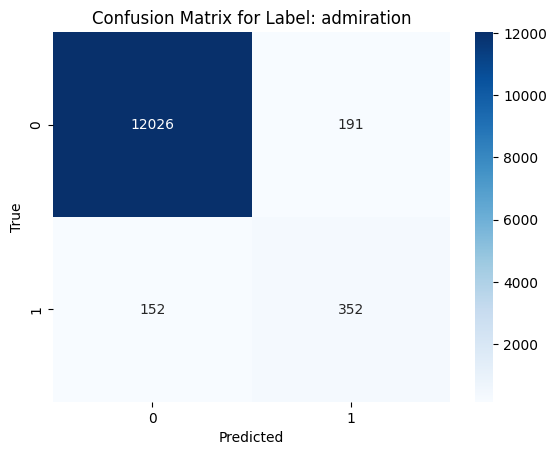

Confusion Matrix for label amusement:
[[12365    92]
 [   33   231]]


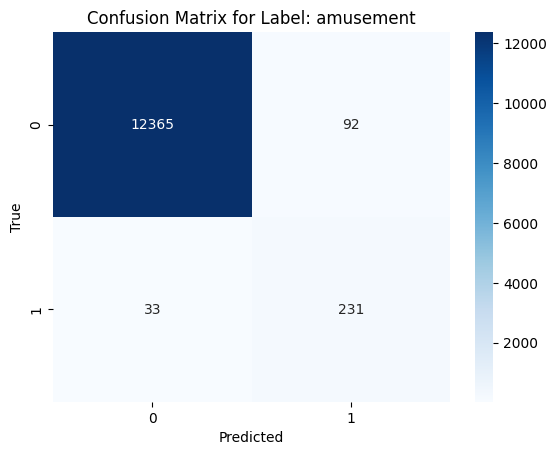

Confusion Matrix for label anger:
[[10839   297]
 [  496  1089]]


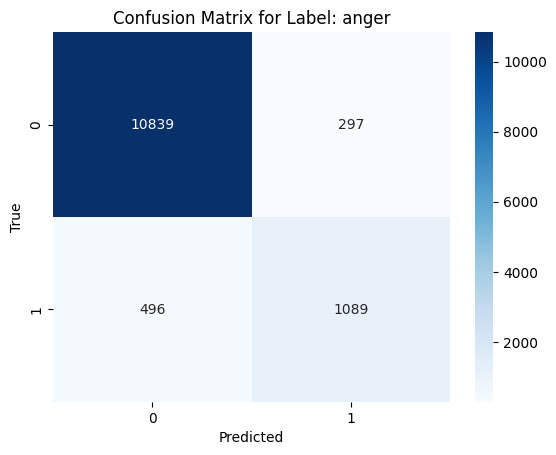

Confusion Matrix for label annoyance:
[[12355    46]
 [  282    38]]


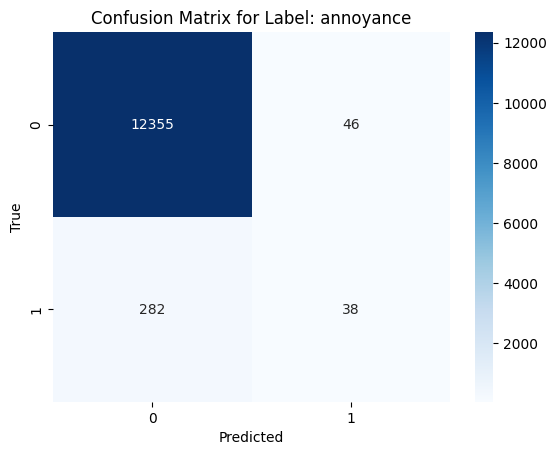

Confusion Matrix for label approval:
[[12313    57]
 [  255    96]]


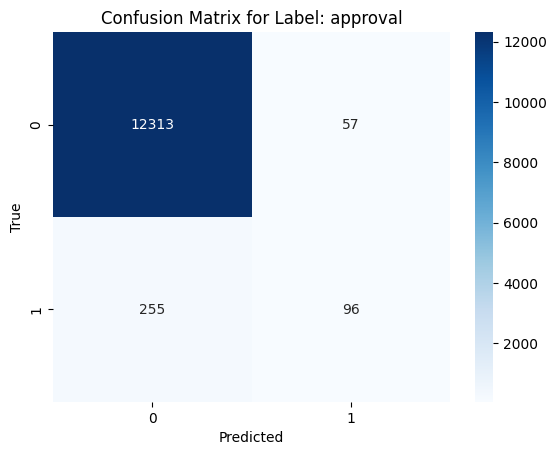

Confusion Matrix for label caring:
[[12526    60]
 [   87    48]]


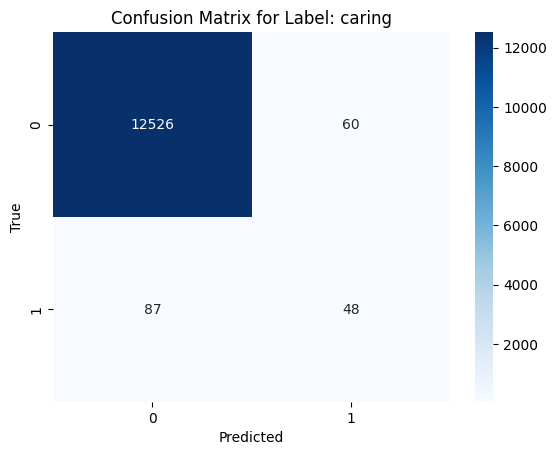

Confusion Matrix for label confusion:
[[12491    77]
 [   93    60]]


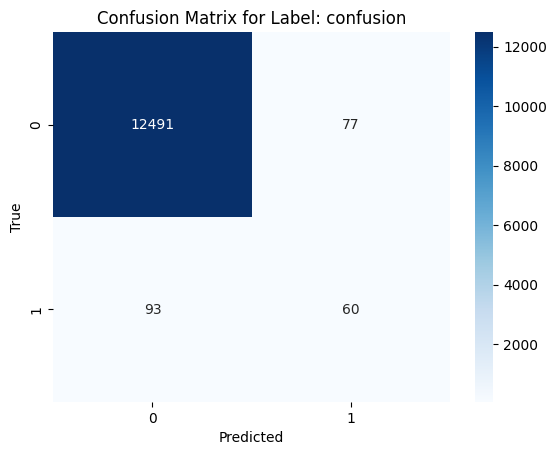

Confusion Matrix for label curiosity:
[[12340    97]
 [  181   103]]


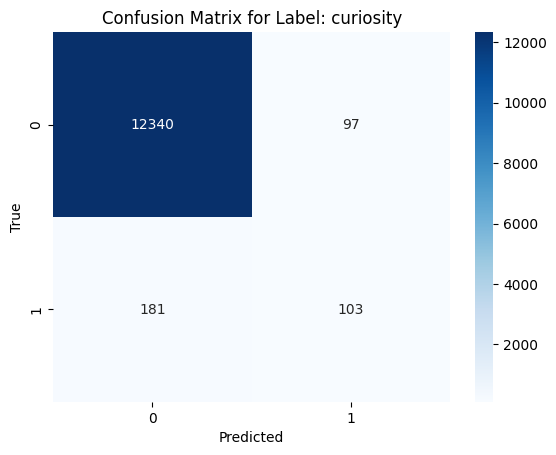

Confusion Matrix for label desire:
[[12607    31]
 [   52    31]]


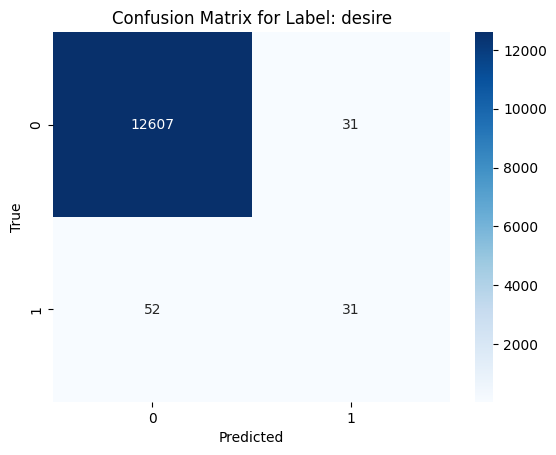

Confusion Matrix for label disappointment:
[[12515    55]
 [  122    29]]


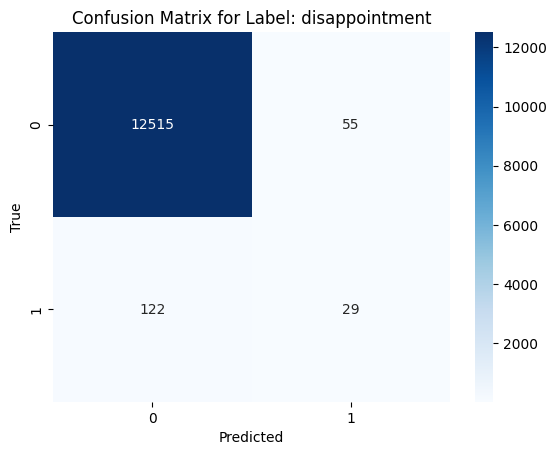

Confusion Matrix for label disapproval:
[[12367    87]
 [  184    83]]


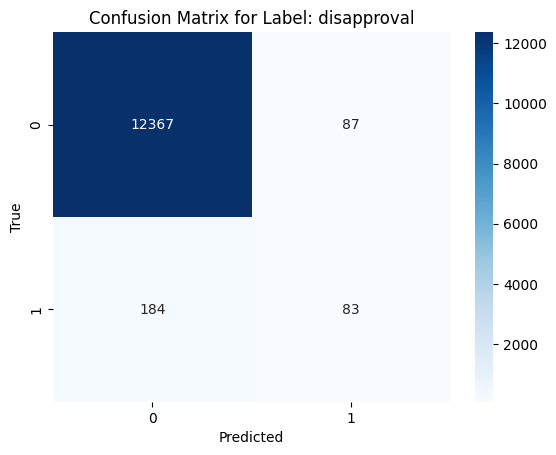

Confusion Matrix for label disgust:
[[11211   288]
 [  470   752]]


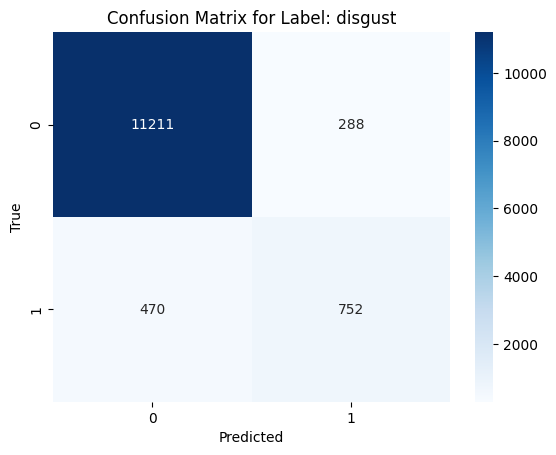

Confusion Matrix for label embarrassment:
[[12678     6]
 [   24    13]]


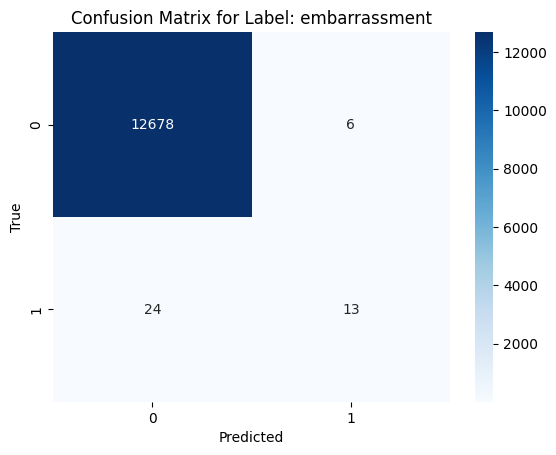

Confusion Matrix for label excitement:
[[12567    51]
 [   59    44]]


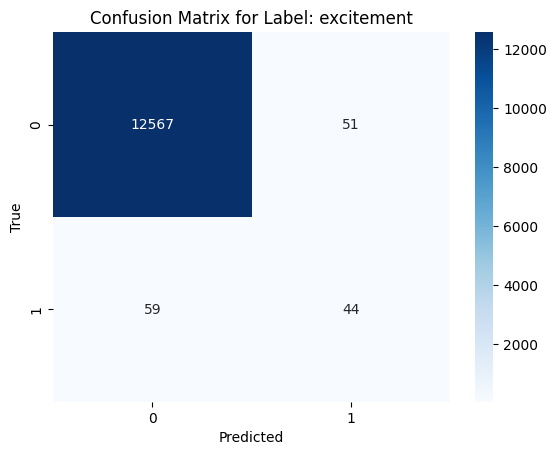

Confusion Matrix for label fear:
[[11804   130]
 [  214   573]]


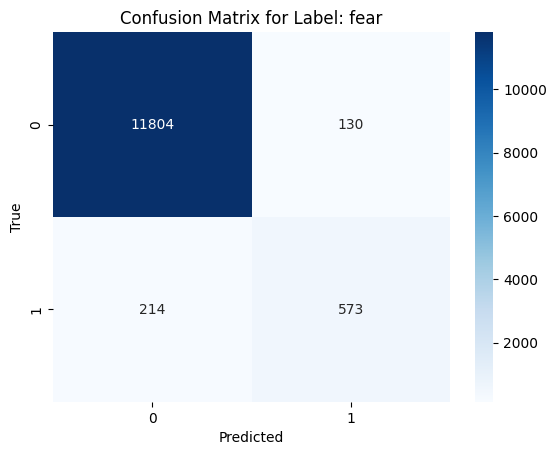

Confusion Matrix for label gratitude:
[[12345    24]
 [   40   312]]


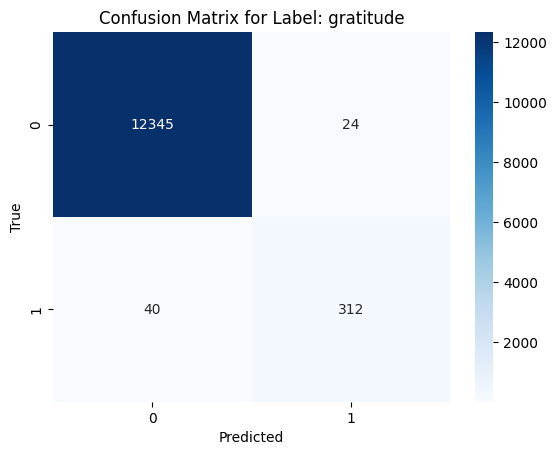

Confusion Matrix for label grief:
[[12715     0]
 [    6     0]]


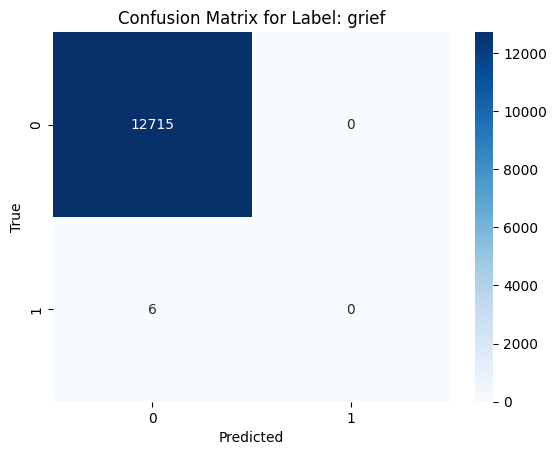

Confusion Matrix for label joy:
[[10115   308]
 [  511  1787]]


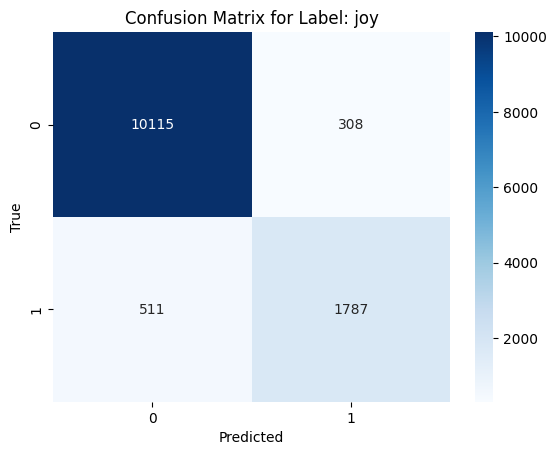

Confusion Matrix for label love:
[[11088   328]
 [  526   779]]


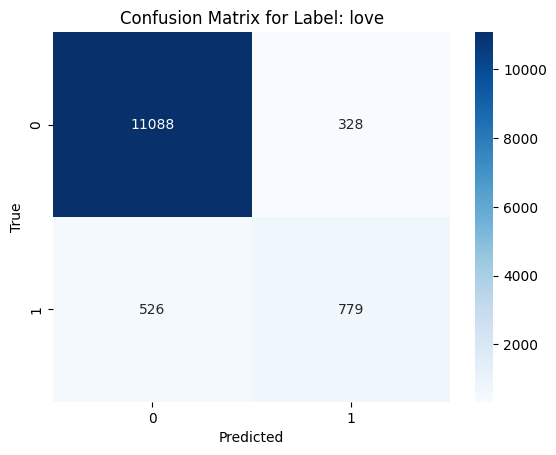

Confusion Matrix for label nervousness:
[[12693     5]
 [   19     4]]


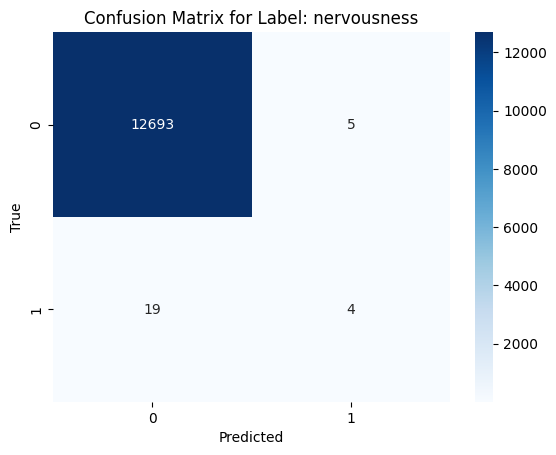

Confusion Matrix for label optimism:
[[11071   321]
 [  582   747]]


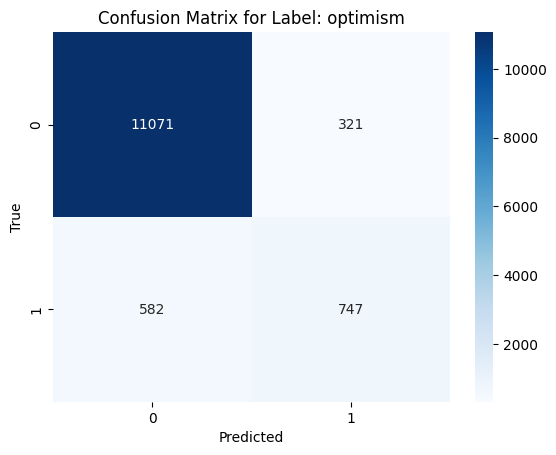

Confusion Matrix for label pride:
[[12705     0]
 [   16     0]]


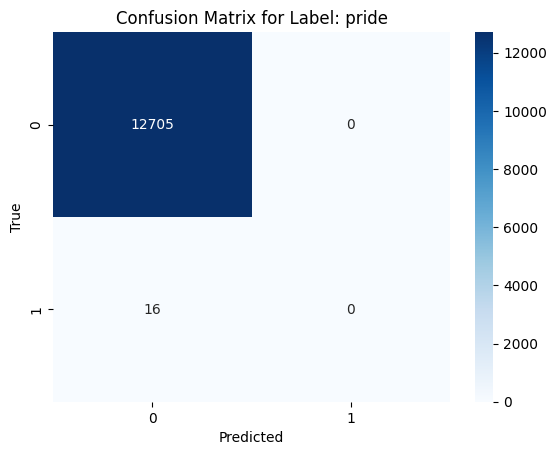

Confusion Matrix for label realization:
[[12534    42]
 [  121    24]]


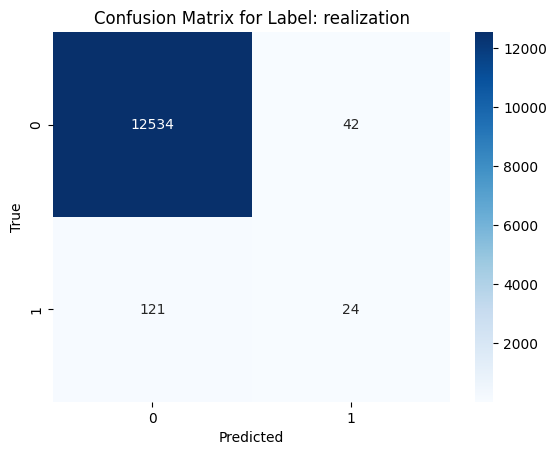

Confusion Matrix for label relief:
[[12469    92]
 [  125    35]]


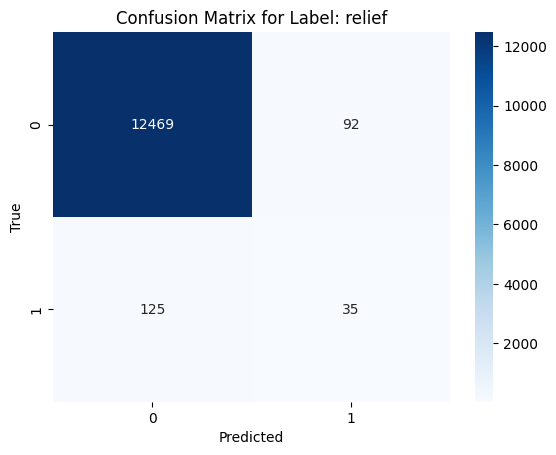

Confusion Matrix for label remorse:
[[12634    31]
 [   11    45]]


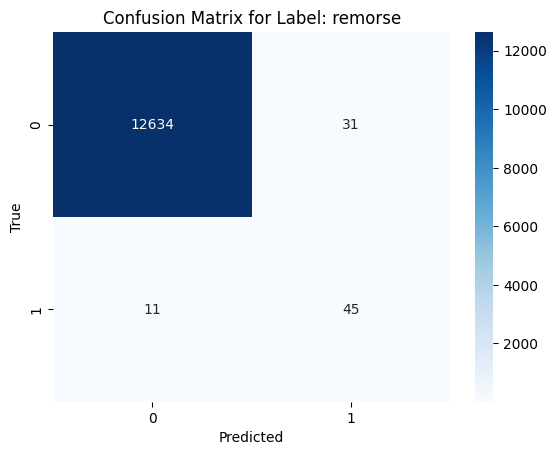

Confusion Matrix for label sadness:
[[10092   417]
 [  759  1453]]


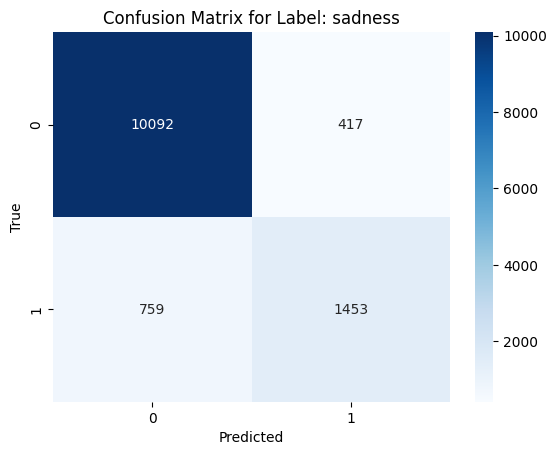

Confusion Matrix for label surprise:
[[12050    99]
 [  404   168]]


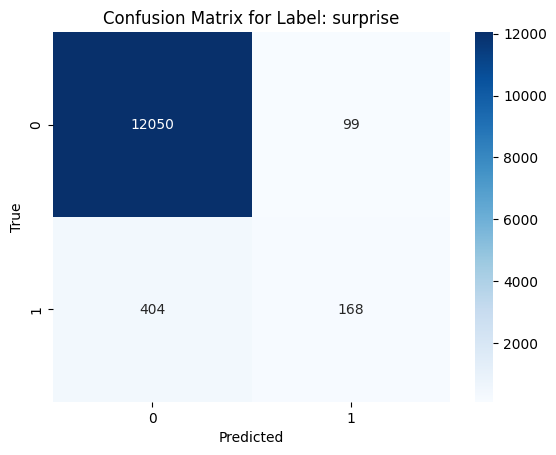

Confusion Matrix for label neutral:
[[9453  600]
 [1270 1398]]


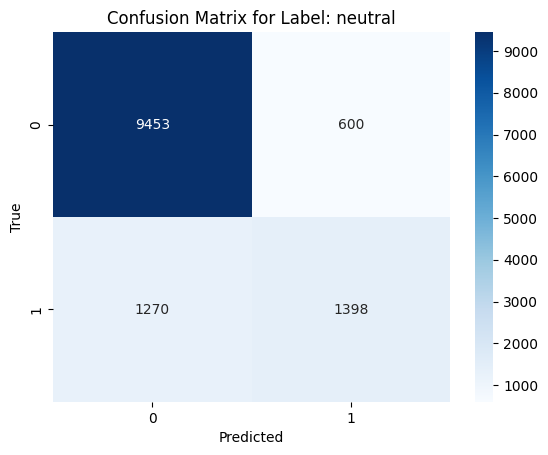

In [30]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mcm = multilabel_confusion_matrix(true_labels, y_pred)

for i in range(mcm.shape[0]):
    print(f"Confusion Matrix for label {labels[i]}:")
    print(mcm[i])
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for Label: {labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()